In [1]:
import sys
import os

import neo.io

import numpy as np
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.pyplot import cm
%matplotlib inline

import tqdm

from collections import Counter

import pandas as pd

from statistics import calc_cv, calc_burst_by_mean, calc_local_variance

from sklearn.metrics import silhouette_score

from scipy.optimize import minimize
from scipy.misc import factorial

from collections import defaultdict

import statsmodels.stats.api as sms

import seaborn as sns

import itertools

from sklearn.decomposition import FastICA, PCA
from sklearn.manifold import TSNE

import re

C:\Users\vladka\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def plot_spikes(spikes, ax=None, figsize=None):
    if ax is None:
        f, ax = plt.subplots(figsize=figsize)

    for i in range(len(spikes)):
        ax.plot([spikes[i], spikes[i]], [-1, 1], color='black', lw=0.2)
    
    ax.set_ylim([-5., 5.])
    ax.get_yaxis().set_visible(False)

In [3]:
def read_spikes(dist_dir):
    all_data = list()

    for root, subdirs, files in os.walk(dist_dir):
        for full_name, f_name in [(os.path.join(root, f_name), f_name) for f_name in files]:
            patient = full_name.split(os.sep)[3]
            ext = full_name[-3:].lower()

            if ext == 'nex':
                r = neo.io.NeuroExplorerIO(filename=full_name)
                for blk in r.read(cascade=True, lazy=False):
                    for seg in blk.segments:
                        for st in seg.spiketrains:
                            name_lower = str(st.name.lower())
                            if name_lower.startswith('fon'):
                                spikes = np.array(st)
                                for interval in seg.epochs:
                                    int_name = interval.annotations['channel_name'].lower()
                                    if name_lower.startswith(int_name):
                                        for s, d in zip(interval.times, interval.durations):
                                            e = s + d
                                            spikes_filtered = spikes[np.where((spikes >= s) & (spikes <= e))]
                                            if len(spikes_filtered) > 100 and (spikes_filtered[~0] - spikes_filtered[0]) > 5.:
                                                isi = spikes_filtered[1:] - spikes_filtered[:-1]
                                                
                                                df = dict()                                              
                                                df['st'] = spikes_filtered
                                                df['cv'] = calc_cv(isi)
                                                df['AI'] = calc_burst_by_mean(isi)
                                                df['patient'] = patient
                                                df['data_name'] = st.name
                                                df['doc_name'] = f_name
                                                df['interval_name'] = int_name
                                                df['lv'] = calc_local_variance(isi)
                                                df['fpath'] = full_name

                                                all_data.append(df)

                            elif name_lower.startswith('allfile') or name_lower.startswith('nw'):
                                spikes = np.array(st)
                                if len(spikes) > 50 and (spikes[~0] - spikes[0] > 5.):  
                                    isi = spikes[1:] - spikes[:-1]
                                    
                                    df = dict()
                                    df['st'] = spikes
                                    df['cv'] = calc_cv(isi)
                                    df['AI'] = calc_burst_by_mean(isi)
                                    df['patient'] = patient
                                    df['data_name'] = st.name
                                    df['doc_name'] = f_name
                                    df['interval_name'] = 'allfile'
                                    df['lv'] = calc_local_variance(isi)
                                    df['fpath'] = full_name

                                    all_data.append(df)
                                    
    return all_data


In [4]:
def clever_split(arr, step):
    res = list()
    
    idx = 0
    for l in np.arange(0, arr[~0], step):
        curr = list()
        while(idx < len(arr) and arr[idx] < l + step):
            curr.append(arr[idx])
            idx += 1
        
        res.append(curr)
    
    return res

def get_sdh(st, norm = True):
    isi = st[1:] - st[:-1]
    splitted = clever_split(st, np.mean(isi))
    counts = Counter([len(t) for t in splitted])
        
    res = np.zeros(max(counts.keys()) + 1)
    
    for idx, val in counts.items():
        res[idx] = val
    
    if(norm):
        res /= sum(res)
    
    return res 

def pad_to_size(arr, sz, val):
    res = np.full(sz, val, dtype=float)
    res[:len(arr)] = arr
    
    return res


In [5]:
dist_dir_a = '..\\neuro_data\\data_for_analyze\\awake'
dist_dir_s = '..\\neuro_data\\data_for_analyze\\sleep'
dist_dir_cd = '..\\neuro_data\\data_for_analyze\\cd_patients'

In [6]:
data_a = read_spikes(dist_dir_a)
data_s = read_spikes(dist_dir_s)
data_cd = read_spikes(dist_dir_cd)

In [7]:
only_st = list()
names = list()
awake_type = list()
cv_ai = list()

for d in data_a:
    if len(d['st']) > 100:
        only_st.append(d['st'])
        names.append('{};{};{}'.format(d['fpath'], d['data_name'], d['interval_name']))
    
        awake_type.append('Local')
        cv_ai.append((d['cv'], d['AI'], d['lv']))

        
    
for d in data_s:
    if len(d['st']) > 100:
        only_st.append(d['st'])
        names.append('{};{};{}'.format(d['fpath'], d['data_name'], d['interval_name']))
    
        cv_ai.append((d['cv'], d['AI'], d['lv']))
        awake_type.append('Generalized')
        
for d in data_cd:
    if len(d['st']) > 100:
        only_st.append(d['st'])
        names.append('{};{};{}'.format(d['fpath'], d['data_name'], d['interval_name']))
    
        cv_ai.append((d['cv'], d['AI'], d['lv']))
#         awake_type.append('CD')

        d = names[~0].split('\\')[~0].split(';')[0].replace('_', '.')
        vals = re.findall("\d+\.\d+", d)
        d = float(vals[0])
        
        if d < 6: 
            awake_type.append('GPi')
        else:
            awake_type.append('GPe')

cv_ai = np.array(cv_ai)

In [8]:
sdh_vals = np.array([get_sdh(st) for st in tqdm.tqdm_notebook(only_st)])

A Jupyter Widget

In [9]:
# cv_ai = [stat_dict[n] for n in names]
only_isi = np.array([st[1:] - st[:-1] for st in only_st])
logisi = [np.log(isi[np.nonzero(isi)]) for isi in only_isi]
st_lens = [st[~0] - st[0] for st in only_st]
st_spikes = [len(st) for st in only_st]


In [10]:
sdh_lens = np.array([len(s) for s in sdh_vals])
invalid = np.where((sdh_lens >= 15) | (sdh_lens < 4))[0]

only_st = np.delete(only_st, invalid)
cv_ai = np.delete(cv_ai, invalid, axis=0)
sdh_vals = np.delete(sdh_vals, invalid)
awake_type = np.delete(awake_type, invalid)
names = np.delete(names, invalid)

In [11]:
max_len = max([len(s) for s in sdh_vals])
all_padded = np.array([pad_to_size(s, max_len, 0.) for s in sdh_vals])

In [12]:
# depth = list()

# for n, t in zip(names, awake_type):
#     if t == 'CD':
#         d = n.split('\\')[~0].split(';')[0].replace('_', '.')
#         vals = re.findall("\d+\.\d+", d)
        
#         if len(vals) > 1:
#             print(n, vals)

#         depth.append(float(vals[0]))
#     else:
#         depth.append(-1)

# depth = np.array(depth)

In [13]:
def boot_fit(x, dist, iters=100):
    params = np.array([dist.fit(np.random.choice(x, size=len(x))) for _ in range(iters)])
    return np.mean(params, axis=0)

# def JSD(P, Q):
#     _P = P / np.linalg.norm(P, ord=1)
#     _Q = Q / np.linalg.norm(Q, ord=1)
#     _M = 0.5 * (_P + _Q)
#     return 0.5 * (sp.stats.entropy(_P, _M) + sp.stats.entropy(_Q, _M))

def JSD(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    p = np.asarray(p)
    q = np.asarray(q)
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.

def logisi_gamma_metric(x, y):
    x_norm = x/np.max(x)
    y_norm = y/np.max(y)
    
    a1,b1,s1 = sp.stats.gamma.fit(x)
    a2,b2,s2 = sp.stats.gamma.fit(y)
    
    x_axis = np.arange(-10, 10, 0.001)
    d1 = sp.stats.gamma.pdf(x_axis, a1, b1, s1)
    d2 = sp.stats.gamma.pdf(x_axis, a2, b2, s2)
    
    return JSD(d1, d2)

def get_sdh_window(st, windows=5):
    splits = np.array_split(st, windows)
    sdh_lst = [get_sdh(spl) for spl in splits]
    max_len = max([len(sdh) for sdh in sdh_lst])
    
    sdh_lst = [pad_to_size(sdh, max_len, 0.) for sdh in sdh_lst]
    
    sdh_total = np.sum(sdh_lst, axis=0)
    
    sdh_total /= sum(sdh_total)
    return sdh_total


def sdh_poisson_metric(x, y, windows=10):
    sdh1 = get_sdh_window(x, windows)
    sdh2 = get_sdh_window(y, windows)
        
    max_len = max(len(sdh1), len(sdh2))

    sdh1 = pad_to_size(sdh1, max_len, 0)
    sdh2 = pad_to_size(sdh2, max_len, 0)

    return JSD(sdh1, sdh2)


def build_matrix_precalc(arr, metric, cashed):
    res = np.zeros((len(arr), len(arr)), dtype=float)
    
    for i in tqdm.tnrange(len(arr)):
        for j in range(i + 1, len(arr)):
            m = metric(arr[i], arr[j])
            if np.isfinite(m):
                res[i,j] = res[j, i] = m
            else:
                res[i,j] = res[j, i] = 1.
    
    return res 


def build_matrix(arr, metric):
    res = np.zeros((len(arr), len(arr)), dtype=float)
    
    for i in tqdm.tnrange(len(arr)):
        for j in range(i + 1, len(arr)):
            m = metric(arr[i], arr[j])
            if np.isfinite(m):
                res[i,j] = res[j, i] = m
            else:
                res[i,j] = res[j, i] = 1.
    
    return res

In [14]:
def sdh_poisson_metric_precalc(sdh1, sdh2):
    max_len = max(len(sdh1), len(sdh2))

    sdh1_p = pad_to_size(sdh1, max_len, 0)
    sdh2_p = pad_to_size(sdh2, max_len, 0)

    return JSD(sdh1_p, sdh2_p)


def build_matrix_precalc(arr, metric, cashed):
    res = np.zeros((len(arr), len(arr)), dtype=float)
    
    for i in tqdm.tnrange(len(arr), leave=False):
        for j in range(i + 1, len(arr)):
            m = metric(cashed[i], cashed[j])
            if np.isfinite(m):
                res[i,j] = res[j, i] = m
            else:
                res[i,j] = res[j, i] = 1.
    
    return res 


In [15]:
def find_cut(Z, num, l = 0.05, r = 1):
    t = (l + r)/2
    curr_cut = fcluster(Z, t, criterion='distance')
    curr_num = len(np.unique(curr_cut))
    
    while curr_num != num:        
        if curr_num > num:
            l = t
            t = (t + r)/2
        elif curr_num < num:
            r = t
            t = (t + l)/2
            
        t = (l + r)/2
        curr_cut = fcluster(Z, t, criterion='distance')
        curr_num = len(np.unique(fcluster(Z, t, criterion='distance')))
    
    return t, curr_cut

In [16]:
M = build_matrix_precalc(only_st, lambda x, y: sdh_poisson_metric_precalc(x, y), sdh_vals)

A Jupyter Widget

In [17]:
# hierarchy.set_link_color_palette([mpl.colors.to_hex(c) for c in ['r', 'b', 'g']])

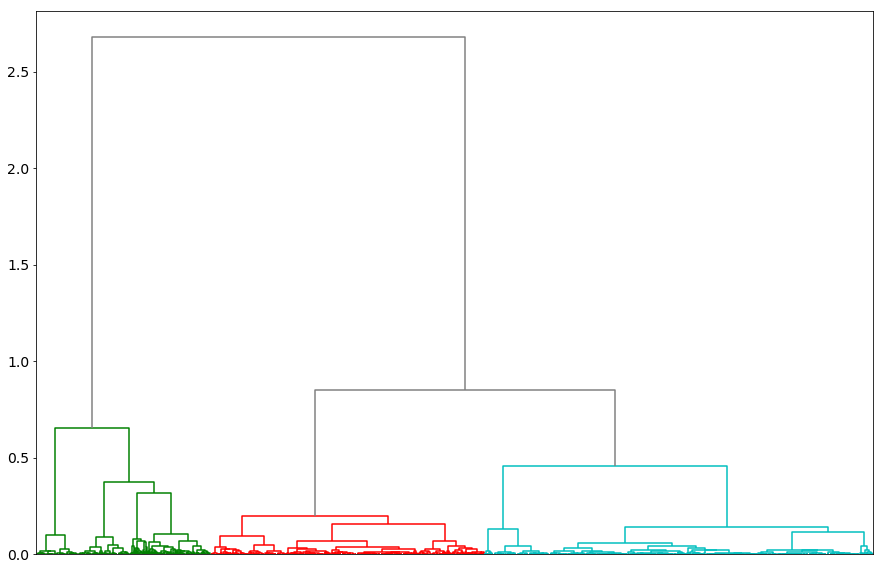

In [18]:
Z = linkage(M[np.triu_indices(M.shape[0], 1)], 'ward')

t, cut = find_cut(Z, 3)

plt.figure(figsize=(15,10))

d_dct = dendrogram(Z, color_threshold=t, above_threshold_color="grey")
_ = plt.xticks([])
ax = plt.gca()

for item in [ax.title, ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(20)
    
for item in ax.get_yticklabels():
    item.set_fontsize(14)

In [19]:
# silh_score = dict()
# for t in np.linspace(0.3, M.max()*2):
#     curr_cut = fcluster(Z, t, criterion='distance')
#     sscore =  silhouette_score(M, curr_cut, metric='precomputed')
    
#     silh_score[len(np.unique(curr_cut))] = sscore

In [20]:
def calc_mean_sdh(vals):
    max_len = max([len(v) for v in vals])
#     res = np.zeros(max_len)
    padded = np.array([pad_to_size(v, max_len, 0.)/sum(v) for v in vals])
    
    return np.mean(padded, axis=0)

def calc_average_dist(X, labels):
    res = 0.
    dist_list = list()
    for l in np.unique(labels):
        idx = np.where(labels == l)[0]
        centroid = calc_mean_sdh(X[idx])
                
        for val in X[idx]:
            d = sdh_poisson_metric_precalc(val, centroid)
            dist_list.append(d)
#             curr_dist.append() 
#             res += sdh_poisson_metric_precalc(val, centroid)
        
    
    return np.mean(dist_list)
#     return res

In [21]:
# mean_dist = dict()
# for t in np.linspace(0.1, M.max()*2):
#     curr_cut = fcluster(Z, t, criterion='distance')
#     mean_dist[len(np.unique(curr_cut))] = calc_average_dist(sdh_vals, curr_cut)

In [22]:
# plt.figure(figsize=(15,10))
# for l, col, name in zip(np.unique(cut), ['r','g','b'], ['burst', 'tonic', 'irregular']):
#     idx = np.where(cut == l)
#     plt.scatter(cv_ai[idx, 0], cv_ai[idx, 1], color=col, s=5, label=name)
# # plt.scatter([c[0] for c in cv_ai], [c[1] for c in cv_ai], cmap='plasma', c=cut, s=5)

# plt.xlim([0, 10])

# plt.xlabel('CV')
# plt.ylabel('AI')
# plt.legend()

In [23]:
# sdh_dct = dict()
# for l in np.unique(cut):
#     idx = np.where(cut == l)
#     sdh_dct[l] = sdh_vals[idx]

In [24]:
cvai_stats = dict()
for l in np.unique(cut):
    idx = np.where(cut == l)
    print(l)
    print(np.median(cv_ai[idx], axis=0))
    print(np.min(cv_ai[idx], axis=0))
    print(np.max(cv_ai[idx], axis=0))

1
[ 1.50567189  0.5004293   0.73032552]
[ 0.58365766  0.05576518  0.19782641]
[ 14.15687915   0.90987701   1.52447104]
2
[ 1.37735375  0.53853914  0.74645411]
[ 0.71861832  0.28795707  0.21170958]
[ 7.72070199  0.87793888  1.19217697]
3
[ 1.01016377  0.68634875  0.62433773]
[ 0.3792396   0.48668966  0.13000917]
[ 2.47229141  1.02530597  1.20324084]


In [25]:
# sdh_padded = dict()
# for k, val in sdh_dct.items():
#     max_len = np.max([len(s) for s in val])
#     print(np.max([len(s) for s in val]), np.median([len(s) for s in val]))
    
#     padded = np.array([pad_to_size(sdh, max_len, 0.) for sdh in val])
#     sdh_padded[k] = padded

In [26]:
# mean_unpadded = dict()
# for name, (k, val) in zip(['burst', 'tonic', 'irregular'], sdh_padded.items()): 
#     mean_unpadded[name] = np.mean(val, axis=0) 
    
# max_len = max([len(val) for val in mean_unpadded.values()])
# mean_unpadded = {k: pad_to_size(val, max_len, 0.) for k, val in mean_unpadded.items()}

In [27]:
# pd.DataFrame(mean_unpadded).to_csv('SDH_table.csv')

In [28]:
# mean_dct = dict()
# for name, (k, val) in zip(['burst', 'irregular', 'tonic'], sdh_padded.items()):
#     mean_sdh = np.mean(val, axis=0)
    
#     if len(mean_sdh) < 10:
#         mean_sdh = pad_to_size(mean_sdh, 10, 0.)
#     else:
#         mean_sdh = mean_sdh[:10]
        
#     mean_dct[k] = mean_sdh
    
#     plt.figure()
#     plt.bar(np.arange(10), mean_sdh)
#     plt.title(name)
    
#     plt.xticks(np.arange(10))

In [29]:
def get_cluster_dists(mean_dct, sdh):       
#     res, min_dist = -1, 100500
    res = np.zeros(3)
    for k, val in mean_dct.items():
        curr_dist = sdh_poisson_metric_precalc(sdh, val)
        res[k-1] = curr_dist
#         if curr_dist < min_dist:
#             res, min_dist = k, curr_dist
    
    return res
    

In [30]:
mean_dct = {k:np.mean(all_padded[cut == k], axis=0) for k in np.unique(cut)}
dists = np.array([get_cluster_dists(mean_dct, sdh) for sdh in sdh_vals])
st_lens = np.array([st[~0] - st[0] for st in only_st])
# labels = np.argmin(dists, axis=1) + 1
labels = cut
# most_similar = np.argmin(dists, axis=0)
# most_similar = [23, 1358, 1394]

In [31]:
for l in np.unique(cut):
    idx = np.argsort(dists[:, l-1])[:10]
    print(l, idx, st_lens[idx])

1 [  23 1119 1403 1172 1857 1990 1276 1367 1808 1116] [ 27.75566128  35.55761883  58.15017639  51.54282552  28.86145484
  18.91890226  24.49191332  39.80198848  12.8897982   35.58432275]
2 [  97 1358 1789  205  780 1787  737 1786 1892 1961] [  82.47863669   21.71915785   19.95788963   88.1189872    36.85355453
  169.73110991  120.86619996  169.4848567   214.78040985  235.62528758]
3 [ 865  271  812 1394 1848 1849 1975 1716 1576 1048] [ 119.65707783   12.456784    132.31081148   22.97240503    8.22718467
    8.22718467   98.40121606   46.49181621   76.44848907   23.36670638]


In [32]:
# plt.figure(figsize=(15,10))
# for l, col, name in zip(np.unique(cut), ['r','g','b'], ['burst', 'tonic', 'irregular']):
#     idx = np.where(cut == l)
#     plt.scatter(cv_ai[idx, 0], cv_ai[idx, 1], color=col, s=5, label=name)
# # plt.scatter([c[0] for c in cv_ai], [c[1] for c in cv_ai], cmap='plasma', c=cut, s=5)

# plt.xlim([0, 10])

# plt.xlabel('CV')
# plt.ylabel('AI')
# plt.legend()

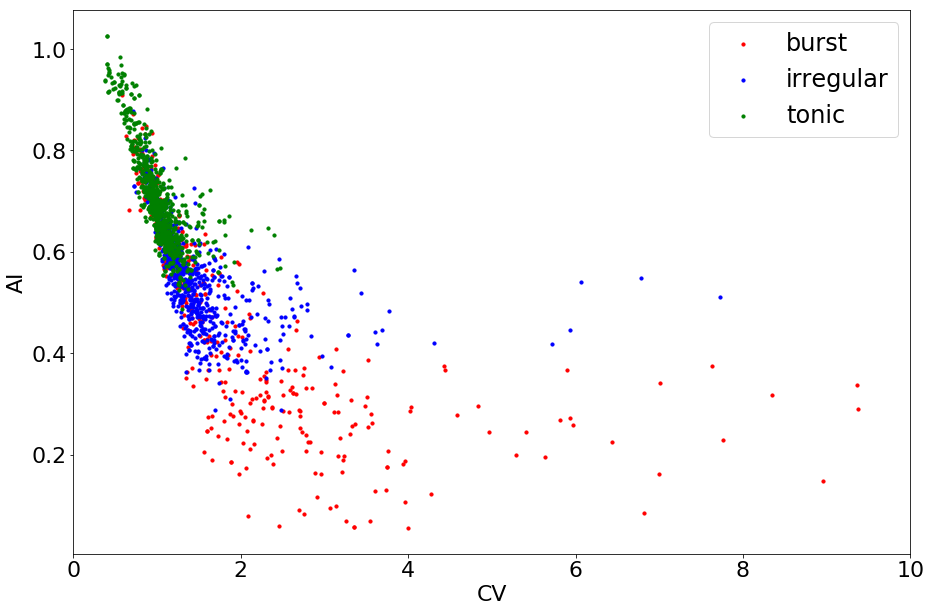

In [34]:
plt.figure(figsize=(15,10))
for l, col, name in zip(np.unique(labels), ['r','b','g'], ['burst', 'irregular', 'tonic']):
    idx = np.where(labels == l)
    plt.scatter(cv_ai[idx, 0], cv_ai[idx, 1], color=col, s=10, label=name)
# plt.scatter([c[0] for c in cv_ai], [c[1] for c in cv_ai], cmap='plasma', c=cut, s=5)

plt.xlim([0, 10])

plt.xlabel('CV')
plt.ylabel('AI')
plt.legend(prop={'size': 24})

ax = plt.gca()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(22)

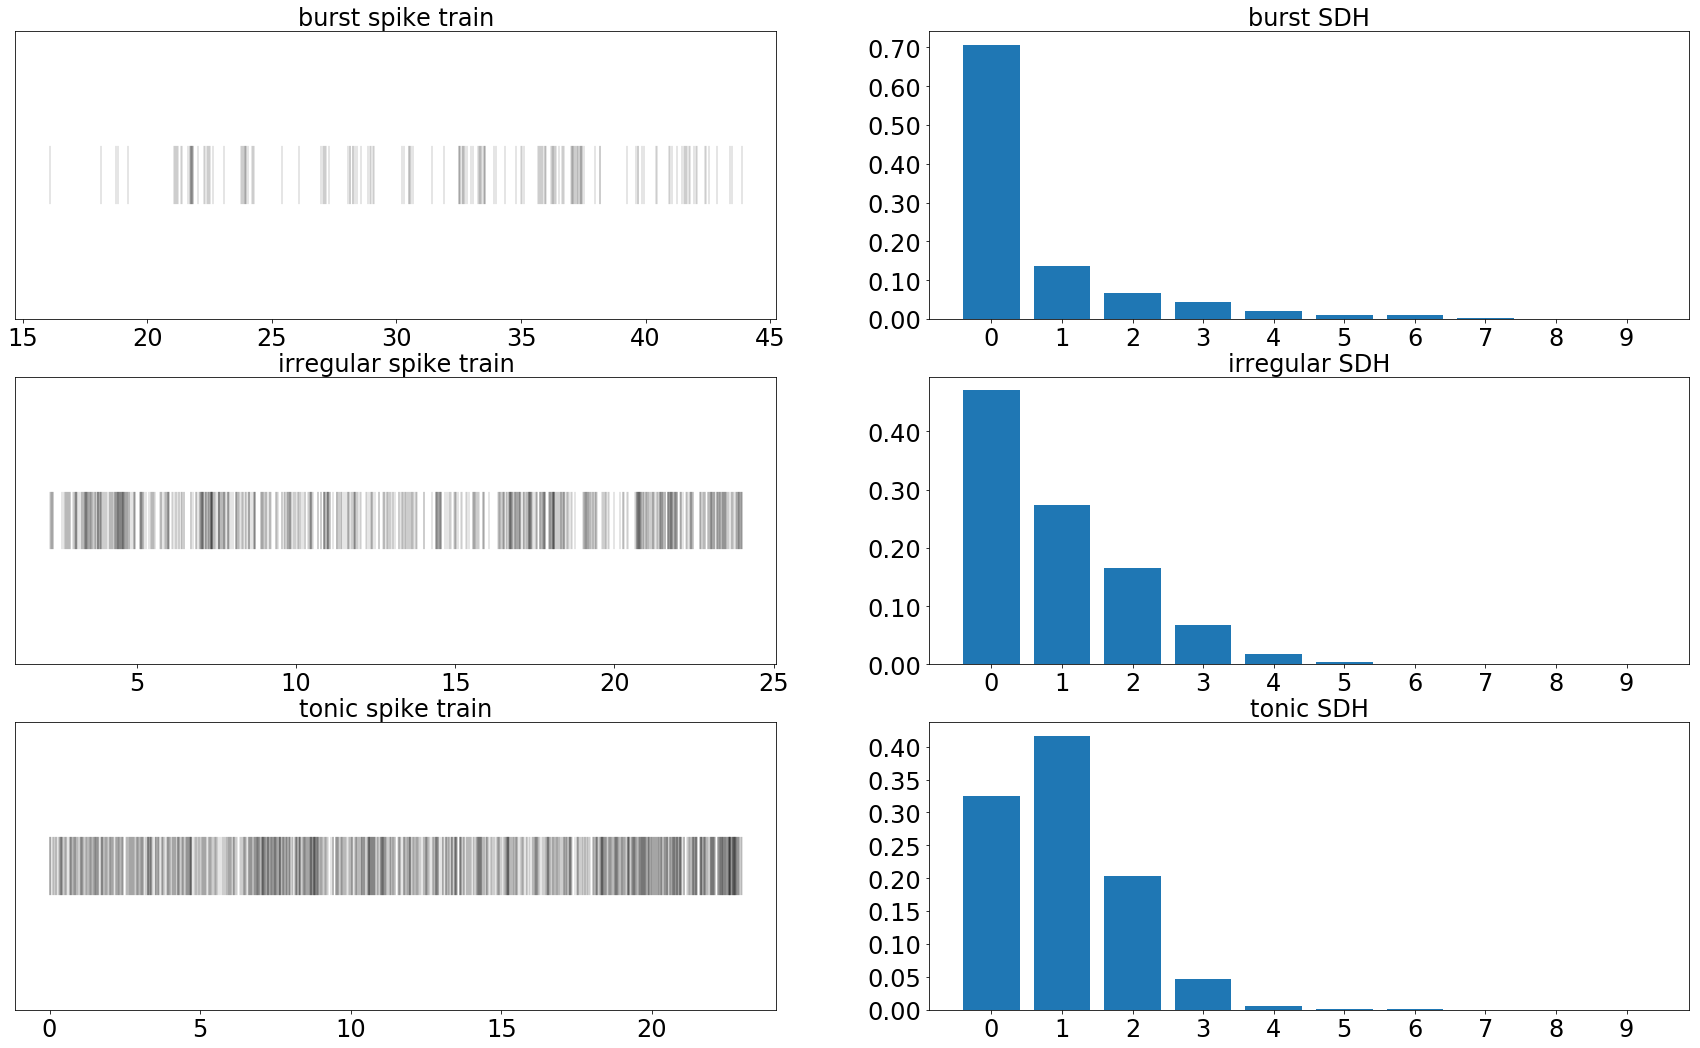

In [48]:
fig, axes = plt.subplots(3, 2, figsize=(30, 18))
for i, (idx, name) in enumerate(zip(most_similar, ['burst', 'irregular', 'tonic'])):
#     plt.figure()
    curr_sdh = sdh_vals[idx]
    
    if len(curr_sdh) < 10:
        curr_sdh = pad_to_size(curr_sdh, 10, 0.)
    
    ax1, ax2 = axes[i]
    plot_spikes(only_st[idx], ax=ax1)
    ax2.bar(np.arange(curr_sdh.shape[0]), curr_sdh)
    
    ax1.set_title('{} spike train'.format(name))
    ax2.set_title('{} SDH'.format(name))
    ax2.set_xticks(np.arange(curr_sdh.shape[0]))
    
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    

for ax in axes.flatten():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)
        

In [43]:
# f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,10))

# fig = plt.figure(1, figsize=(15,10))
# gridspec.GridSpec(2,3)

# sdh = get_sdh(tonic_inc)
# plt.subplot2grid((2,3), (0,0))
# plt.bar(np.arange(sdh.shape[0]), sdh)
# plt.title('no windows')

# sdh_w = get_sdh_window(tonic_inc, windows=5)
# plt.subplot2grid((2,3), (0,1))
# plt.bar(np.arange(sdh_w.shape[0]), sdh_w)
# plt.title('5 windows')
# plt.xlim([-0.5, 5.5])

# sdh_w = get_sdh_window(tonic_inc, windows=25)
# plt.subplot2grid((2,3), (0,2))
# plt.bar(np.arange(sdh_w.shape[0]), sdh_w)
# plt.title('25 windows')
# plt.xlim([-0.5, 5.5])

# plt.subplot2grid((2,3), (1,0), colspan=3, rowspan=1)
# for i in range(len(tonic_inc)):
#     plt.plot([tonic_inc[i], tonic_inc[i]], [-1, 1], color='black', lw=0.25)

# plt.ylim([-5., 5.])

In [42]:
def get_counts(st, return_counter=False):
    isi = st[1:] - st[:-1]
    splitted = clever_split(st, np.mean(isi))
    lens = [len(t) for t in splitted]

    if return_counter:
        return Counter(lens)
    else:
        return lens

In [43]:
just_lens = dict()
for l in np.unique(labels):
    idx = np.where(labels == l)[0]
    
    res = list()
    for i in idx:
        res += get_counts(only_st[i])
        
    just_lens[l] = res

In [173]:
def poisson(k, params):
    lamb = params[0]
    """poisson pdf, parameter lamb is the fit parameter"""
    return (lamb**k/factorial(k)) * np.exp(-lamb)

def cmpoisson(x, params):    
    lamb, v = params
    
    def z():
        return sum([lamb**j/(factorial(j)**v) for j in range(0, 100)])
    
    return (lamb**x)/(factorial(x)**v)*1./z()

def nbinom_sp(x, params):
    r, p = params
    
    return sp.stats.nbinom.pmf(x, r, p)

def negLogLikelihood(params, data, dist=poisson):
    """ the negative log-Likelohood-Function"""
    lnl = -np.sum(np.log(dist(data, params)))
    return lnl

burst, Dist params: [ 0.33775731  0.44980973]
irregular, Dist params: 0.9184978960627885
tonic, Dist params: (0.99194038736810108, 0.90341436060863878)


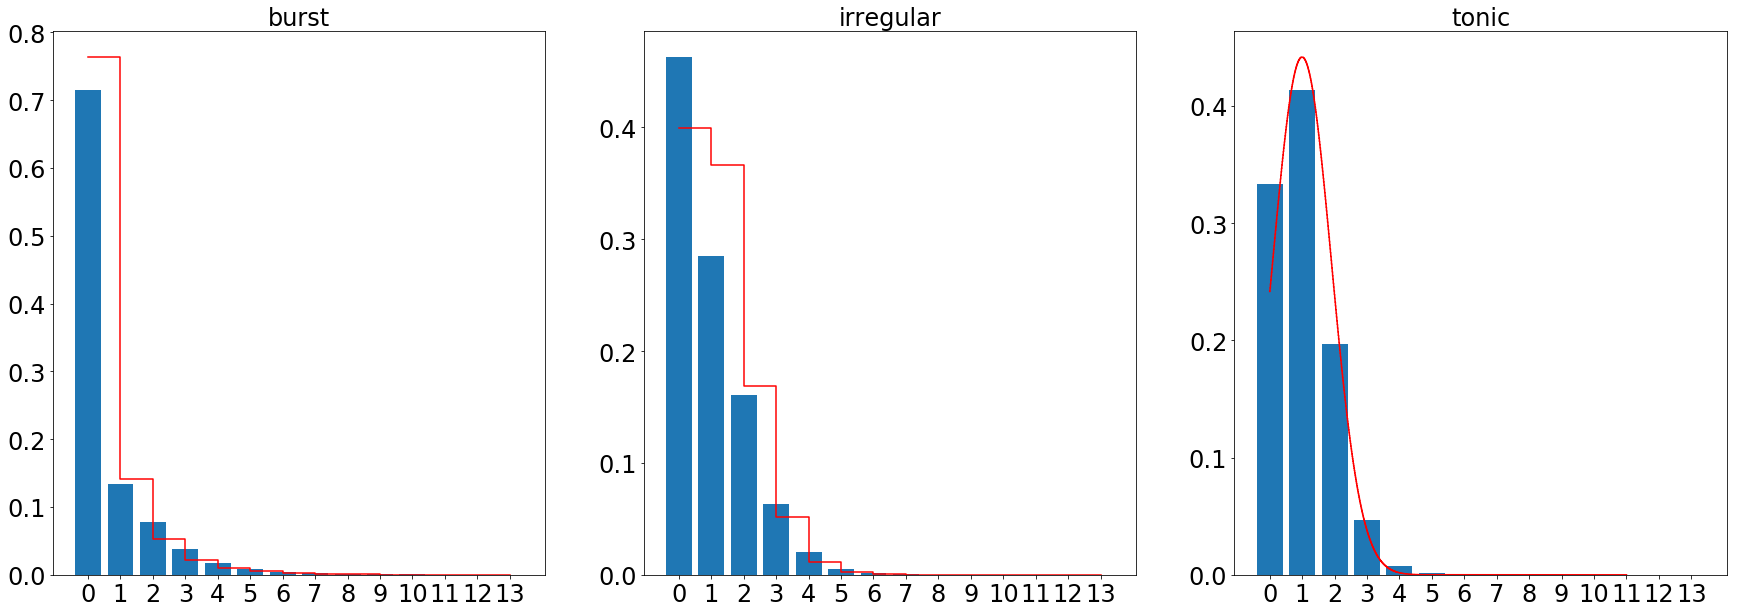

In [191]:
fig, axes = plt.subplots(ncols=3, figsize=(30,10))

for name, (k, val) in zip(['burst', 'irregular', 'tonic'], just_lens.items()):
    x = np.arange(mean_dct[k].shape[0])
    y = mean_dct[k]
    
    if k == 3:
        x_vals = np.linspace(0, max(val), endpoint=True, num=1000)
        u, v = sp.stats.norm.fit(val)
        pdf_vals = sp.stats.norm.pdf(x_vals, loc=u, scale=v)
        dist_params = (u, v)
    elif k == 1:
        x_vals = x
        res = minimize(lambda x,y: negLogLikelihood(x,y, nbinom_sp), x0=np.array([0.5, 0.5]), args=(val,), method='SLSQP', bounds=((0.005, 10),(0.005, 10)))
        pdf_vals = nbinom_sp(x_vals, res.x)
        dist_params = res.x
    else:
        x_vals = x
        res = minimize(negLogLikelihood, x0=np.ones(1), args=(val,), method='L-BFGS-B', bounds=((0.0005, 10),))
        dist_params = res.x[0]
        pdf_vals = poisson(x_vals, res.x)
        
    print('{}, Dist params: {}'.format(name, dist_params))
    
#     plt.figure()
    axes[k-1].bar(x, y)
    axes[k-1].step(x_vals, pdf_vals, color='r', where='post')
    axes[k-1].set_xticks(x)
    
    axes[k-1].set_title(name)
    
for ax in axes.flatten():
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)

In [47]:
counts_lst = [get_counts(st) for st in only_st]

In [212]:
boot_dct = defaultdict(list)

for name, k  in zip(['burst', 'irregular', 'tonic'], [1,2,3]):
    l_idx = np.where(labels == k)[0]
    for _ in tqdm.tnrange(100, desc=name):
        curr_idx = np.random.choice(l_idx, l_idx.shape[0])
        
        curr_val = list()
        for i in curr_idx:
            curr_val.extend(counts_lst[i])
#         curr_val = sum([counts_lst[i] for  in curr_idx], list())
        if k == 3:
            u, v = sp.stats.norm.fit(curr_val)
            dist_params = (u, v)
            boot_dct['tonic_mean'].append(u)
            boot_dct['tonic_var'].append(v)
        elif k == 1:
            res = minimize(lambda x,y: negLogLikelihood(x,y, nbinom_sp), x0=np.array([0.5, 0.5]), args=(curr_val,), method='SLSQP', bounds=((0.005, 10),(0.005, 10)))
            r, p = res.x
            boot_dct['burst_succ'].append(r)
            boot_dct['burst_prob'].append(p)
        else:
            res = minimize(negLogLikelihood, x0=np.ones(1), args=(curr_val,), method='SLSQP', bounds=((0.0005, 10),))
            dist_params = res.x[0]            
            boot_dct['irregular'].append(dist_params)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [218]:
# boot_dct = defaultdict(list)

# for name, (k, val) in zip(['burst', 'tonic', 'irregular'], [just_lens.items()]):
#     for _ in tqdm.tnrange(1000, desc=name):
#         curr_val = np.random.choice(val, len(val))
#         if k == 2:
#             u, v = sp.stats.norm.fit(curr_val)
#             dist_params = (u, v)
#         else:
#             res = minimize(negLogLikelihood, x0=np.ones(1), args=(curr_val,), method='L-BFGS-B', bounds=((0.0005, 10),))
#             dist_params = res.x[0]
            
#         boot_dct[k].append(dist_params)

In [219]:
df = pd.DataFrame(boot_dct)

In [220]:
df.aggregate(['mean'])

,burst_prob,burst_succ,irregular,tonic_mean,tonic_var
mean,0.448671,0.33832,0.917659,0.991958,0.903576


In [221]:
# for c in df.columns:
#     print(c, sms.DescrStatsW(df[c]).tconfint_mean())

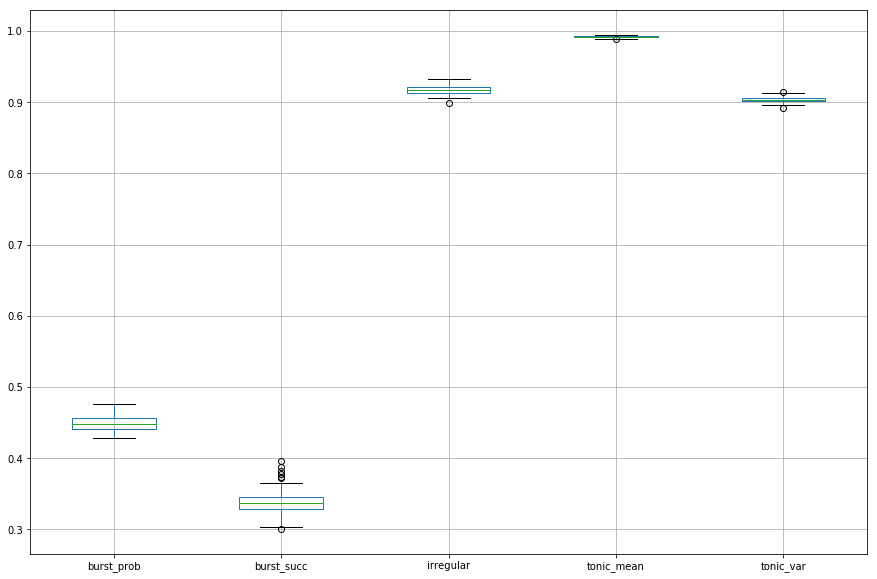

In [222]:
plt.figure(figsize=(15,10))
df.boxplot()

In [ ]:
sp.stats.n

burst, Dist params: (0.98939773107501039, 0.90147758740863082)
irregular, Dist params: (0.98939773107501039, 0.90147758740863082)
tonic, Dist params: (0.98939773107501039, 0.90147758740863082)


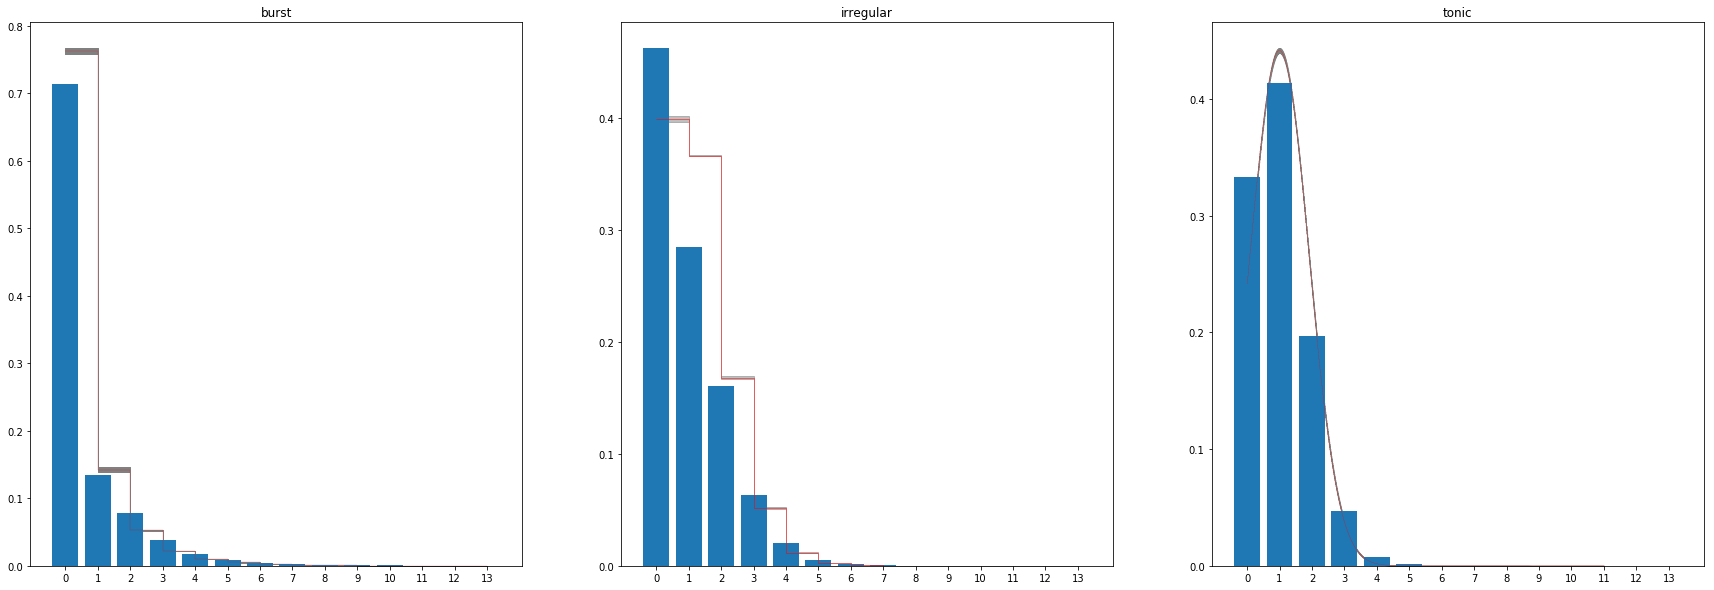

In [236]:
fit, axes = plt.subplots(ncols=3, figsize=(30,10))

for name, (k, val) in zip(['burst', 'irregular', 'tonic'], just_lens.items()):
    x = np.arange(mean_dct[k].shape[0])
    y = mean_dct[k]
    
    curr_ax = axes[k - 1]
    curr_ax.bar(x, y)
    curr_ax.set_xticks(x)
    
    if k == 3:
        x_vals = np.linspace(0, max(val), endpoint=True, num=100)
        u, v = df['tonic_mean'].mean(), df['tonic_var'].mean()
        
#         u_l, u_h = sms.DescrStatsW(df['norm_mean']).tconfint_mean()
#         v_l, v_h = sms.DescrStatsW(df['norm_var']).tconfint_mean()
        u_l, u_h = u - df['tonic_mean'].std(), u + df['tonic_mean'].std()
        v_l, v_h = v - df['tonic_var'].std(), v + df['tonic_var'].std()
        
    
        pdf_l = sp.stats.norm.pdf(x_vals, loc=u_l, scale=v_l)
        pdf_h = sp.stats.norm.pdf(x_vals, loc=u_h, scale=v_h)
        
        pdf_vals = sp.stats.norm.pdf(x_vals, loc=u, scale=v)
        curr_ax.step(x_vals, pdf_vals, color='r', where='post', lw=0.2)
        curr_ax.fill_between(x_vals, pdf_l, pdf_h, color='gray', step='post')
    elif k == 1:
        x_vals = x
        r, p = df['burst_succ'].mean(), df['burst_prob'].mean()
        
#         u_l, u_h = sms.DescrStatsW(df['norm_mean']).tconfint_mean()
#         v_l, v_h = sms.DescrStatsW(df['norm_var']).tconfint_mean()
        r_l, r_h = r - df['burst_succ'].std(), r + df['burst_succ'].std()
        p_l, p_h = p - df['burst_prob'].std(), p + df['burst_prob'].std()
        
    
        pdf_l = sp.stats.nbinom.pmf(x_vals, r_l, p_l)
        pdf_h = sp.stats.nbinom.pmf(x_vals, r_h, p_h)
        
        pdf_vals = sp.stats.nbinom.pmf(x_vals, r, p)
        curr_ax.step(x_vals, pdf_vals, color='r', where='post', lw=0.2)
        curr_ax.fill_between(x_vals, pdf_l, pdf_h, color='gray', step='post')
    else:
        u = df[name].mean()
        
#         u_l, u_h = sms.DescrStatsW(df[name]).tconfint_mean()
        u_l, u_h = u - df[name].std(), u + df[name].std()
        
        pdf_l = poisson(x, [u_l])
        pdf_h = poisson(x, [u_h])
        
        pdf_vals = poisson(x, [u])
        curr_ax.step(x, pdf_vals, color='r', where='post', lw=0.5)
        curr_ax.fill_between(x, pdf_l, pdf_h, color='gray', step='post', alpha=0.5)
        
    print('{}, Dist params: {}'.format(name, dist_params))    
    
    curr_ax.set_title(name)

In [49]:
name_map = {1: 'burst', 2: 'irregular', 3:'tonic'}

In [104]:
labels_centroid = np.argmin(dists, axis=1) + 1

In [50]:
df = pd.DataFrame({'pattern':[name_map[l] for l in labels] , 'anesthesia':awake_type})
df = df.join(pd.get_dummies(df['pattern'])).drop(['pattern'], axis=1)


In [51]:
df.groupby('anesthesia').count()

,burst,irregular,tonic
anesthesia,,,
GPe,627,627,627
GPi,798,798,798
Generalized,127,127,127
Local,475,475,475


In [52]:
grouped = df.groupby('anesthesia').sum()

In [53]:
# totals = [i+j+k for i,j,k in zip(grouped['burst'], grouped['irregular'], grouped['tonic'])]
totals = grouped.sum(axis=1).values
greenBars = [i / j * 100. for i,j in zip(grouped['burst'], totals)]
orangeBars = [i / j * 100. for i,j in zip(grouped['irregular'], totals)]
blueBars = [i / j * 100. for i,j in zip(grouped['tonic'], totals)]


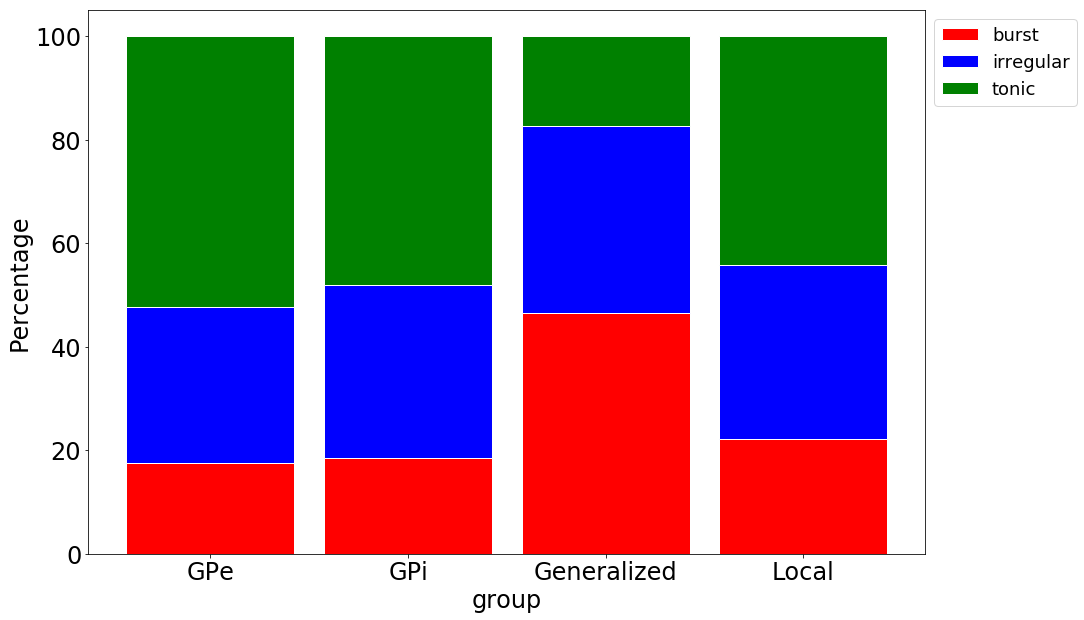

In [54]:
plt.figure(figsize=(15,10))

barWidth = 0.85
r = [0, 1, 2, 3]
names = ('GPe', 'GPi', 'Generalized', 'Local')
# Create green Bars
plt.bar(r, greenBars, color='red', edgecolor='white', width=barWidth, label='burst')
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='blue', edgecolor='white', width=barWidth, label='irregular')
# Create blue Bars
plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='green', edgecolor='white', width=barWidth, label='tonic')


# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
plt.ylabel('Percentage')

plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, prop={'size':18})

ax = plt.gca()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)




In [79]:
(grouped.values.T / np.sum(grouped.values, axis=1)).T

array([[ 0.1754386 ,  0.30143541,  0.523126  ],
       [ 0.18546366,  0.33458647,  0.47994987],
       [ 0.46456693,  0.36220472,  0.17322835],
       [ 0.22105263,  0.33684211,  0.44210526]])

In [82]:
from sklearn.preprocessing import normalize, scale

In [83]:
# pca_model = PCA(n_components=2).fit(normalize(all_padded, axis=0))
# # pca_model = PCA(n_components=2).fit(all_padded)

# pca_trans = pca_model.transform(all_padded)
# plt.figure(figsize=(15,10))

# for l, name, col in zip(np.unique(cut), ['burst', 'irregular', 'tonic'], ['r', 'b', 'g']):
#     idx = np.where(cut == l)
#     plt.scatter(pca_trans[idx,0], pca_trans[idx,1],  label=name, color=col)
    
# plt.legend(prop={'size':24})
# # plt.title('PCA')

# ax = plt.gca()

# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(18)

In [84]:
pca_model_10 = PCA(n_components=10).fit(normalize(all_padded, axis=0))

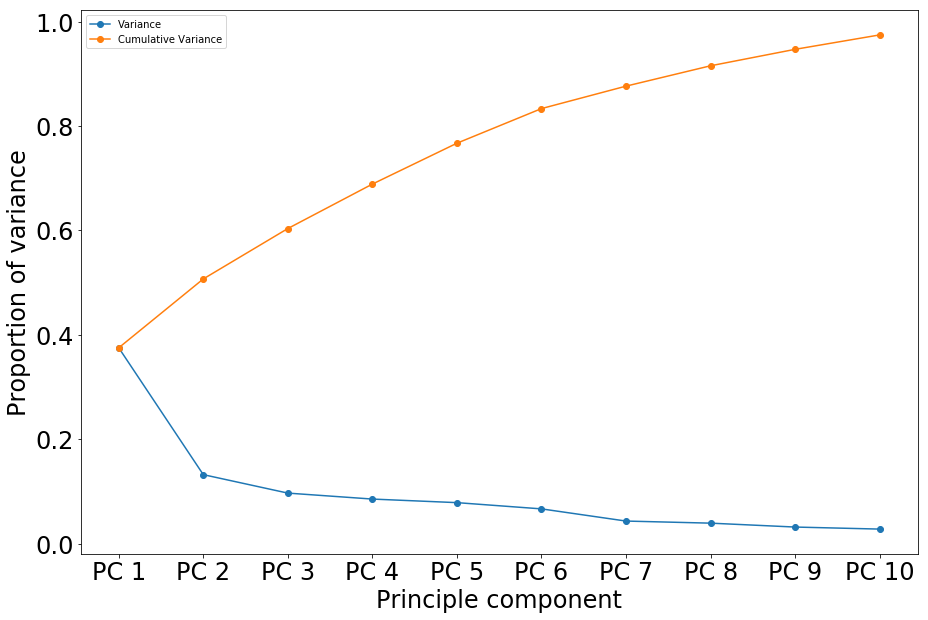

In [94]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(1, 11), pca_model_10.explained_variance_ratio_, marker='o', label='Variance')
plt.plot(np.arange(1, 11), np.cumsum(pca_model_10.explained_variance_ratio_), marker='o', label='Cumulative Variance')
_ = plt.xticks(np.arange(1, 11), ['PC {}'.format(i) for i in np.arange(1, 11)])

# plt.title('PCA explained variance')
plt.ylabel('Proportion of variance')
plt.xlabel('Principle component')
plt.legend()

ax = plt.gca()

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

In [96]:
sum(pca_model_10.explained_variance_ratio_)

0.97468433597339377

In [72]:
import os
desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop') 

In [73]:
# tsne_trans = TSNE(n_components=2).fit_transform(normalize(all_padded, axis=0))
# plt.figure(figsize=(15,10))

# for l, name, col in zip(np.unique(cut), ['burst', 'irregular', 'tonic'], ['r', 'g', 'b']):
#     idx = np.where(cut == l)    
#     plt.scatter(tsne_trans[idx,0], tsne_trans[idx,1], label=name, color=col)
    
# plt.title('TSNE')
# plt.legend()

In [75]:
M_dct = dict()

for l in np.unique(awake_type):
    M_curr = build_matrix_precalc(only_st[awake_type == l], lambda x, y: sdh_poisson_metric_precalc(x, y), sdh_vals[awake_type == l])
    M_dct[l] = M_curr

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [76]:
# boot_dct = defaultdict(list)

# for name, k  in zip(['burst', 'irregular', 'tonic'], [1,2,3]):
#     l_idx = np.where(labels == k)[0]
#     for _ in tqdm.tnrange(100, desc=name):
#         curr_idx = np.random.choice(l_idx, l_idx.shape[0])
        
#         curr_val = list()
#         for i in curr_idx:
#             curr_val.extend(counts_lst[i])
# #         curr_val = sum([counts_lst[i] for  in curr_idx], list())
#         if k == 3:
#             u, v = sp.stats.norm.fit(curr_val)
#             dist_params = (u, v)
#         else:
#             res = minimize(negLogLikelihood, x0=np.ones(1), args=(curr_val,), method='L-BFGS-B', bounds=((0.0005, 10),))
#             dist_params = res.x[0]
            
#         boot_dct[k].append(dist_params)

In [77]:
counts_lst = np.array(counts_lst)

In [237]:
# sep_res = defaultdict(list)
# sep_boot = dict()

# for n, vals in [('Generalized', M_dct['Generalized'])]:
#     type_idx = (awake_type == n)
#     Z_curr = linkage(vals[np.triu_indices(vals.shape[0], 1)], 'ward')
    
#     for t in np.arange(0.05, 1., 0.05):
#         cut_curr = fcluster(Z_curr, t, criterion='distance')
#         if len(np.unique(cut_curr)) == 3:
#             break
            
#     if len(np.unique(cut_curr)) != 3:
#         raise RuntimeError('WTF')

#     fig = plt.figure(figsize=(15,10))
#     # set up subplot grid
#     gridspec.GridSpec(3,3)
#     # large subplot
#     plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
#     ax = plt.gca()
#     _ = dendrogram(Z_curr, color_threshold=t, above_threshold_color="grey", ax=ax)
#     _ = plt.xticks([])
#     plt.title(n)
    
#     sep_res['structure'].append(n)
#     boot_dct = defaultdict(list)
    
#     for idx, l in enumerate(np.unique(cut_curr)):
#         plt.subplot2grid((3, 3), (idx, 2))
                
#         mean_sdh = np.mean(all_padded[awake_type == n][cut_curr == l], axis=0)
#         if np.argmax(mean_sdh) == 1:
#             pat_name = 'tonic'
#         elif mean_sdh[0]/mean_sdh[1] > 2.25:
#             pat_name = 'burst'
#         else:
#             pat_name = 'irregular'
        
#         pat_perc = 1.*sum(cut_curr == l)/cut_curr.shape[0]
#         plt.bar(np.arange(mean_sdh.shape[0]), mean_sdh)
#         plt.title('{} {}%'.format(pat_name, round(pat_perc, 3)))
        
#         sep_res[pat_name].append(pat_perc)
        
#         l_idx = np.where(cut_curr == l)[0]
#         for _ in tqdm.tnrange(10, desc='{} {}'.format(n, pat_name), leave=False):
#             curr_idx = np.random.choice(l_idx, l_idx.shape[0])

#             curr_val = list()
#             for i in curr_idx:
#                 curr_val.extend(counts_lst[type_idx][i])
                
#             if pat_name == 'tonic':
#                 u, v = sp.stats.norm.fit(curr_val)
#                 dist_params = (u, v)
#             else:
#                 res = minimize(negLogLikelihood, x0=np.ones(1), args=(curr_val,), method='L-BFGS-B', bounds=((0.0005, 10),))
#                 dist_params = res.x[0]

#             boot_dct[pat_name].append(dist_params)
    
#         sep_boot[n] = boot_dct
        
#         break
    
#     plt.savefig(os.path.join(desktop, '{}.png'.format(n)))

In [189]:
# res_p = minimize(negLogLikelihood, x0=np.array([0.5]), args=(curr_val,), method='SLSQP', bounds=((0.0005, 10),))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

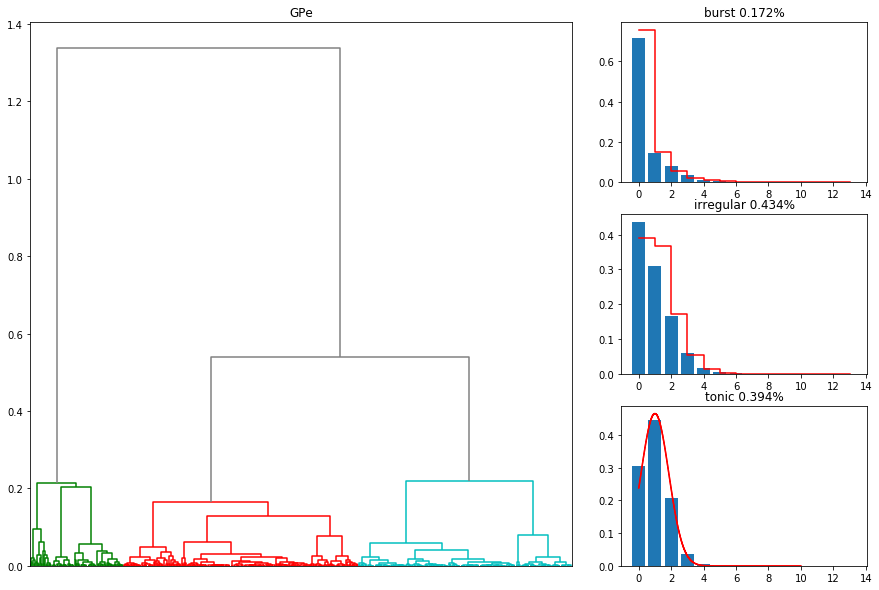

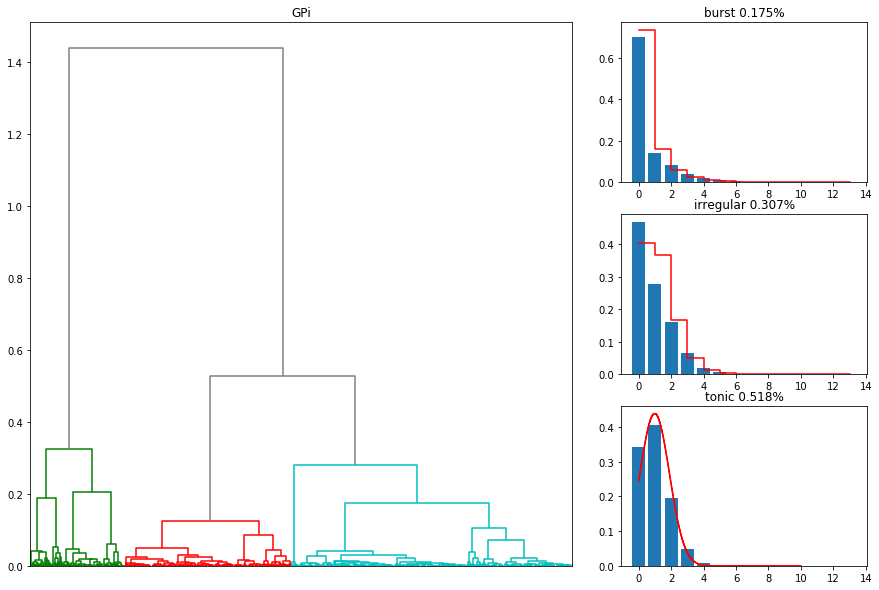

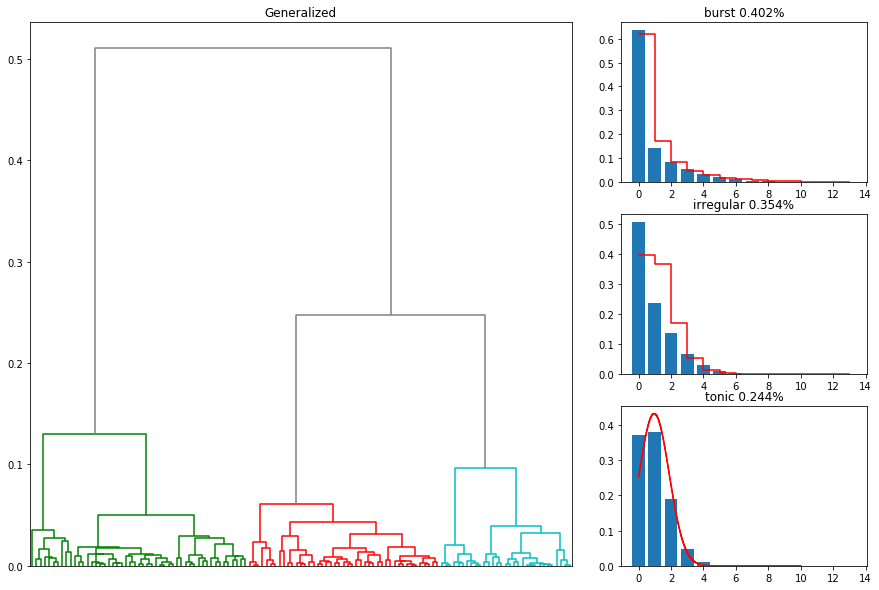

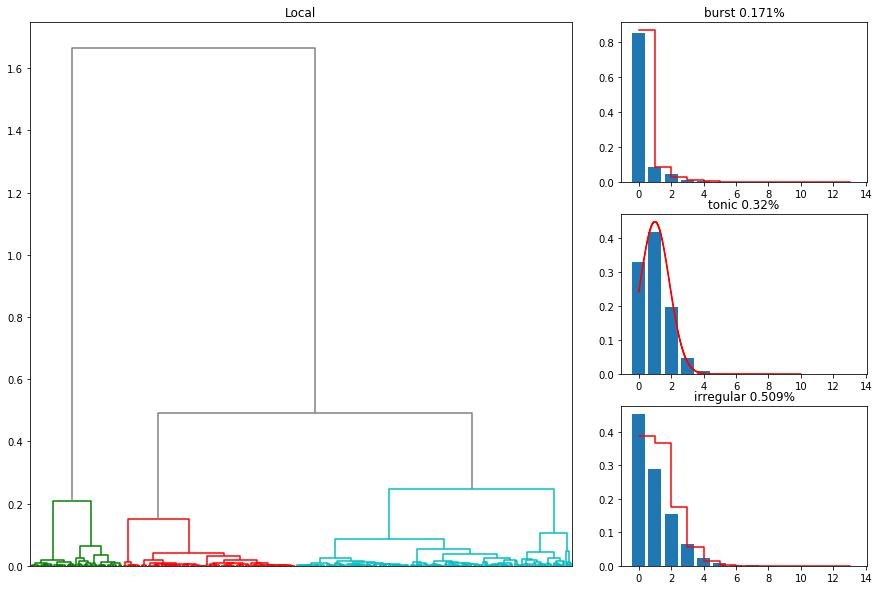

In [241]:
sep_res = defaultdict(list)
sep_boot = dict()

for n, vals in M_dct.items():
    type_idx = (awake_type == n)
    Z_curr = linkage(vals[np.triu_indices(vals.shape[0], 1)], 'ward')
    
    for t in np.arange(0.05, 1., 0.05):
        cut_curr = fcluster(Z_curr, t, criterion='distance')
        if len(np.unique(cut_curr)) == 3:
            break
            
    if len(np.unique(cut_curr)) != 3:
        raise RuntimeError('WTF')

    fig = plt.figure(figsize=(15,10))
    # set up subplot grid
    gridspec.GridSpec(3,3)
    # large subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
    ax = plt.gca()
    _ = dendrogram(Z_curr, color_threshold=t, above_threshold_color="grey", ax=ax)
    _ = plt.xticks([])
    plt.title(n)
    
    sep_res['structure'].append(n)
    boot_dct = defaultdict(list)
    
    for idx, l in enumerate(np.unique(cut_curr)):
        plt.subplot2grid((3, 3), (idx, 2))
                
        mean_sdh = np.mean(all_padded[awake_type == n][cut_curr == l], axis=0)
        if np.argmax(mean_sdh) == 1:
            pat_name = 'tonic'
        elif mean_sdh[0]/mean_sdh[1] > 2.25:
            pat_name = 'burst'
        else:
            pat_name = 'irregular'
        
        pat_perc = 1.*sum(cut_curr == l)/cut_curr.shape[0]
        plt.bar(np.arange(mean_sdh.shape[0]), mean_sdh)
        plt.title('{} {}%'.format(pat_name, round(pat_perc, 3)))
        
        sep_res[pat_name].append(pat_perc)
        
        l_idx = np.where(cut_curr == l)[0]
        for _ in tqdm.tnrange(100, desc='{} {}'.format(n, pat_name), leave=False):
            curr_idx = np.random.choice(l_idx, l_idx.shape[0])

            curr_val = list()
            for i in curr_idx:
                curr_val.extend(counts_lst[type_idx][i])
                
            if pat_name == 'tonic':
                u, v = sp.stats.norm.fit(curr_val)
                dist_params = (u, v)
            elif pat_name == 'burst':
                res = minimize(lambda x,y: negLogLikelihood(x,y, nbinom_sp), x0=np.array([0.5, 0.5]), args=(curr_val,), method='SLSQP', bounds=((0.005, 10),(0.005, 10)))
                dist_params = res.x
            else:
                res = minimize(negLogLikelihood, x0=np.ones(1), args=(curr_val,), method='L-BFGS-B', bounds=((0.0005, 10),))
                dist_params = res.x[0]

            boot_dct[pat_name].append(dist_params)
        
        if pat_name == 'tonic':
            vals = np.array(boot_dct['tonic'])
            u, v = np.mean(vals[:, 0]), np.mean(vals[:, 1])
            
            x_vals = np.linspace(0, 10, endpoint=True, num=1000)
            pdf_vals = sp.stats.norm.pdf(x_vals, u, v)
        elif pat_name == 'burst':
            vals = np.array(boot_dct['burst'])
            r, p = np.mean(vals[:, 0]), np.mean(vals[:, 1])
            
            x_vals = np.arange(mean_sdh.shape[0])
            pdf_vals = sp.stats.nbinom.pmf(x_vals, r, p)
        else:
            vals = np.array(boot_dct['irregular'])
            u = np.mean(vals)
            
            x_vals = np.arange(mean_sdh.shape[0])
            pdf_vals = poisson(x_vals, [u])
        
        plt.step(x_vals, pdf_vals, color='r', where='post')

    sep_boot[n] = boot_dct
    
    plt.savefig(os.path.join(desktop, '{}.png'.format(n)))

In [248]:
for k, pat_dct in sep_boot.items():
    for pat_name, vals in pat_dct.items():
        if pat_name == 'tonic':
            vals = np.array(vals)
            u, v = vals[:, 0], vals[:, 1]
            
            print('{} activity in {} follows gaussian distribution with mean equals to {:.3f} +- {:.3f} and variance {:.3f} +- {:.3f}'.format(pat_name, k, np.mean(u), np.std(u), np.mean(v), np.std(v)), end=', ')
        elif pat_name == 'burst':
            vals = np.array(vals)
            r, p = vals[:, 0], vals[:, 1]
            
            print('{} activity in {} follows negative binomial distribution with number of success equals to {:.3f} +- {:.3f} and probability of a single success {:.3f} +- {:.3f}'.format(pat_name, k, np.mean(r), np.std(r), np.mean(p), np.std(p)), end=', ')
        else:
            print('{} in {} follows poisson distribution with mean equals to {:.3f} +- {:.3f}'.format(pat_name, k, np.mean(vals), np.std(vals)), end=', ')


burst activity in GPe follows negative binomial distribution with number of success equals to 0.385 +- 0.044 and probability of a single success 0.486 +- 0.026, irregular in GPe follows poisson distribution with mean equals to 0.944 +- 0.008, tonic activity in GPe follows gaussian distribution with mean equals to 0.995 +- 0.001 and variance 0.857 +- 0.008, burst activity in GPi follows negative binomial distribution with number of success equals to 0.419 +- 0.038 and probability of a single success 0.480 +- 0.021, irregular in GPi follows poisson distribution with mean equals to 0.909 +- 0.008, tonic activity in GPi follows gaussian distribution with mean equals to 0.981 +- 0.003 and variance 0.910 +- 0.006, burst activity in Generalized follows negative binomial distribution with number of success equals to 0.387 +- 0.027 and probability of a single success 0.292 +- 0.012, irregular in Generalized follows poisson distribution with mean equals to 0.924 +- 0.023, tonic activity in Gener

In [66]:
sep_res = pd.DataFrame(sep_res).groupby('structure').sum()

In [72]:
# totals = [i+j+k for i,j,k in zip(grouped['burst'], grouped['irregular'], grouped['tonic'])]
totals = sep_res.sum(axis=1).values
greenBars = [i / j * 100. for i,j in zip(sep_res['burst'], totals)]
orangeBars = [i / j * 100. for i,j in zip(sep_res['irregular'], totals)]
blueBars = [i / j * 100. for i,j in zip(sep_res['tonic'], totals)]


In [243]:
# plt.figure(figsize=(15,10))

# ax1, ax2 = plt.subplots(ncols=2)

# barWidth = 0.85
# r = [0, 1, 2, 3]
# names = ('GPe', 'GPi', 'Generalized', 'Local')

# plt.bar(r, greenBars, color='red', edgecolor='white', width=barWidth, label='burst')
# plt.bar(r, orangeBars, bottom=greenBars, color='blue', edgecolor='white', width=barWidth, label='irregular')
# plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='green', edgecolor='white', width=barWidth, label='tonic')


# # Custom x axis
# plt.xticks(r, names)
# plt.xlabel("group")
# plt.ylabel('Percentage')

# plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, prop={'size':18})

# ax = plt.gca()

# for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#              ax.get_xticklabels() + ax.get_yticklabels()):
#     item.set_fontsize(24)


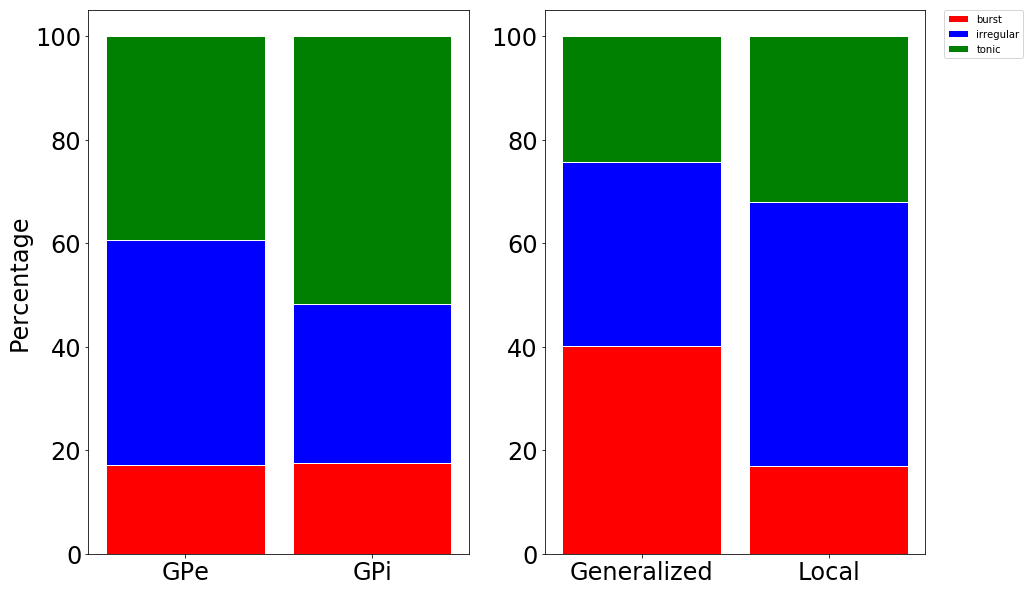

In [87]:
# plt.figure(figsize=(15,10))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,10))

barWidth = 0.85
r = [0, 1, 2, 3]
names = ('GPe', 'GPi', 'Generalized', 'Local')

ax1.bar(r[:2], greenBars[:2], color='red', edgecolor='white', width=barWidth, label='burst')
ax1.bar(r[:2], orangeBars[:2], bottom=greenBars[:2], color='blue', edgecolor='white', width=barWidth, label='irregular')
ax1.bar(r[:2], blueBars[:2], bottom=[i+j for i,j in zip(greenBars, orangeBars)][:2], color='green', edgecolor='white', width=barWidth, label='tonic')

ax1.set_xticks(r[:2])
ax1.set_xticklabels(names[:2])
ax1.set_ylabel('Percentage')

ax2.bar(r[:2], greenBars[2:], color='red', edgecolor='white', width=barWidth, label='burst')
ax2.bar(r[:2], orangeBars[2:], bottom=greenBars[2:], color='blue', edgecolor='white', width=barWidth, label='irregular')
ax2.bar(r[:2], blueBars[2:], bottom=[i+j for i,j in zip(greenBars, orangeBars)][2:], color='green', edgecolor='white', width=barWidth, label='tonic')
ax2.set_xticks(r[:2])
ax2.set_xticklabels(names[2:])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# # Custom x axis
# plt.xticks(r, names)
# plt.xlabel("group")
# plt.ylabel('Percentage')

# plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, prop={'size':18})

for ax in [ax1, ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(24)


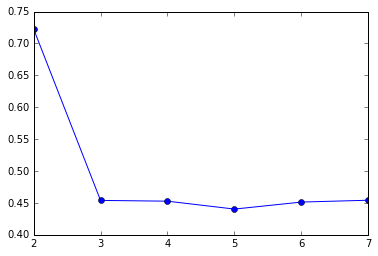

In [69]:
ax1.set_x